<a href="https://colab.research.google.com/github/viniciusrpb/cloud_image_classification/blob/main/invoices_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capítulo 3 - Redes Neurais Artificiais

## 3.4. Estudo de caso: Análise de Sentimentos utilizando uma Rede Neural Profunda

### Tarefa: classificação de polaridade em tweets

Classificar um *tweet* em alguma das três polaridades: positiva (*positive*), negativa (*negative*) e positiva (*neutral*).

### O *corpus*

Para isso, vamos precisar utilizar as bibliotecas keras, tensorflow, numpy, sklearn, matplotlib.

Fonte: [SemEval-2013 Task 2: Sentiment Analysis in Twitter](https://aclanthology.org/S13-2052/)

O *corpus* de tweets empregado nesse estudo de caso podem ser acessados na pasta "corpus_tweets" deste repositório. Segue a especificação de cada arquivo:

*   ```twitter-2013train-A.txt```: conjunto de tweets para treinamento
*   ```twitter-2013dev-A.txt```: conjunto de tweets para validação
*   ```twitter-2013test-A.txt```: conjunto de tweets para testes

In [1]:
!pip install -U keras
!pip install -U tensorflow

In [2]:
from keras.models import Sequential
from keras.layers import Dense,Activation
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

Importando as classes necessárias a partir das bibliotecas

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

### Carregamento do corpus para Pandas DataFrames



**PS.:** Mais informações sobre a divisão de um conjunto de dados em treinamento, validação e teste, você encontra nesse [link](https://machinelearningmastery.com/difference-test-validation-datasets/).


In [4]:
path_train = 'Train.csv'
#path_valid = 'twitter-2013dev-A.txt'
#path_test = 'Test.csv'

In [5]:
df_train = pd.read_csv(path_train,encoding='utf8', sep=',')
#df_test = pd.read_csv(path_test, encoding='utf8', sep=',')

In [6]:
df_train

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description,Product_Category
0,15001,VENDOR-1676,GL-6100410,83.24,Artworking/Typesetting Production Jun 2009 Cha...,CLASS-1963
1,15002,VENDOR-1883,GL-2182000,51.18,Auto Leasing Corporate Services Corning Inc /N...,CLASS-1250
2,15004,VENDOR-1999,GL-6050100,79.02,Store Management Lease/Rent Deltona Corp Real ...,CLASS-1274
3,15005,VENDOR-1771,GL-6101400,48.50,Store Construction General Requirements Coloni...,CLASS-1522
4,15006,VENDOR-1331,GL-2182000,63.35,Jul 2015 Aydin Corp Contingent Labor/Temp Labo...,CLASS-1376
...,...,...,...,...,...,...
5561,23005,VENDOR-1736,GL-2182000,84.88,Human Resources Corporate Services Contingent ...,CLASS-1376
5562,23007,VENDOR-2226,GL-6050310,94.78,Logistics Transportation Services Parcel/Posta...,CLASS-1870
5563,23008,VENDOR-1036,GL-6100500,57.01,2005Sep Addmaster Corp Magazines Media Buy - T...,CLASS-1721
5564,23010,VENDOR-2442,GL-6060100,79.96,Information Technology IT Managed Services Fri...,CLASS-1652


Informações sobre cada parte do *corpus* de tweets:

In [7]:
print(f"O conjunto de treinamento possui {df_train.shape} tweets")
#print(f"O conjunto de validação possui {df_valid.shape} tweets")
#print(f"O conjunto de testes possui {df_test.shape} tweets")

O conjunto de treinamento possui (5566, 6) tweets


### Pré-processamento dos Tweets

Remove o atributo **id**, pois não será necessário o uso desse atributo no processo de classificação.



In [8]:
#df_valid.drop(labels=['Inv_Id'],axis=1)
#df_test.drop(labels=['Inv_Id','Vendor_Code'],axis=1)
df_train.drop(labels=['Inv_Id','Vendor_Code'],axis=1)

,GL_Code,Inv_Amt,Item_Description,Product_Category
0,GL-6100410,83.24,Artworking/Typesetting Production Jun 2009 Cha...,CLASS-1963
1,GL-2182000,51.18,Auto Leasing Corporate Services Corning Inc /N...,CLASS-1250
2,GL-6050100,79.02,Store Management Lease/Rent Deltona Corp Real ...,CLASS-1274
3,GL-6101400,48.50,Store Construction General Requirements Coloni...,CLASS-1522
4,GL-2182000,63.35,Jul 2015 Aydin Corp Contingent Labor/Temp Labo...,CLASS-1376
...,...,...,...,...
5561,GL-2182000,84.88,Human Resources Corporate Services Contingent ...,CLASS-1376
5562,GL-6050310,94.78,Logistics Transportation Services Parcel/Posta...,CLASS-1870
5563,GL-6100500,57.01,2005Sep Addmaster Corp Magazines Media Buy - T...,CLASS-1721
5564,GL-6060100,79.96,Information Technology IT Managed Services Fri...,CLASS-1652


Além disso, por questões do uso dos métodos da classe Sequential no Keras-Tensorflow, convertemos o atributo de classe para o tipo categórico e para cada instância, mapeamos seus valores para números inteiros. Lembre-se que os **modelos de aprendizado de máquina processam apenas números inteiros ou reais**.

In [9]:
df_train['Product_Category'] = pd.Categorical(df_train['Product_Category'])
#df_valid['polarity'] = pd.Categorical(df_valid['polarity'])
#df_test['Product_Category'] = pd.Categorical(df_test['Product_Category'])

train_codes = df_train['Product_Category'].cat.codes
#y_valid = df_valid['polarity'].cat.codes
#y_test = df_test['Product_Category'].cat.codes

Vamos ver como e repare que o mapeamento do atributo categórico "polarity" para valores categóricos inteiros ficou como:

*   polaridade "negativa" *(negative)*: valor $0$
*   polaridade "neutra" *(neutral)*: valor $1$
*   polaridade "positiva" *(positive)*: valor $2$

In [11]:
for i in range(0,5):
    v = df_train['Product_Category'][i]
    print(f'Valor original da classe {v} Transformação inteira: {train_codes[i]}')

Valor original da classe CLASS-1963 Transformação inteira: 25
Valor original da classe CLASS-1250 Transformação inteira: 2
Valor original da classe CLASS-1274 Transformação inteira: 3
Valor original da classe CLASS-1522 Transformação inteira: 10
Valor original da classe CLASS-1376 Transformação inteira: 7


A seguir, transformamos os valores da classe "polaridade", nossa classe de interesse, para one-hot-encoding. Nessa representação, como temos três classes, utilizaremos três bits, em que para cada instância, apenas um deles estará ativado (com valor $1$) com base na presença do valor classe.

Veja como fica a representação one-hot encoding para cada classe:

*   polaridade "negativa" *(negative)*: valor $0$, one hot encoding: $[1,0,0]$
*   polaridade "neutra" *(neutral)*: valor $1$, one hot encoding: $[0,1,0]$
*   polaridade "positiva" *(positive)*: valor $2$, one hot encoding: $[0,0,1]$

Utilizaremos a função *to_categorical* do Keras para esse propósito (se bem que poderíamos facilmente implementar uma por nossa conta):

In [12]:
from keras.utils.np_utils import to_categorical

num_classes = len(df_train['Product_Category'].value_counts())
print(df_train['Product_Category'].value_counts())
print(num_classes)

CLASS-1758    1498
CLASS-1274     986
CLASS-1522     851
CLASS-1250     451
CLASS-1376     365
CLASS-1963     230
CLASS-1249     176
CLASS-1828     113
CLASS-2141     108
CLASS-1721     107
CLASS-1567      84
CLASS-1919      70
CLASS-1850      60
CLASS-2112      53
CLASS-1477      50
CLASS-1870      36
CLASS-2241      36
CLASS-2003      32
CLASS-1309      32
CLASS-1429      32
CLASS-1964      28
CLASS-1322      28
CLASS-1294      25
CLASS-1770      19
CLASS-1983      17
CLASS-1867      15
CLASS-1652      15
CLASS-2038      13
CLASS-1805      12
CLASS-2152       9
CLASS-1248       5
CLASS-1688       4
CLASS-2015       2
CLASS-2146       2
CLASS-1957       1
CLASS-1838       1
Name: Product_Category, dtype: int64
36


Apenas verificando como ficou o pré-processamento do atributo de classe:

In [15]:
#for i in range(0,5):
#    v = df_train['Product_Category'][i]
#    print(f"Invoice {i}: valor original da classe '{v}'; mapeamento para inteiro: {train_codes[i]}; representação one-hot-encoding [{int(y_train_enc[i][0])},{int(y_train_enc[i][1])},{int(y_train_enc[i][2])}]")

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_train['Item_Description'], train_codes, test_size=0.33, random_state=42)

In [19]:
y_train_enc = to_categorical(y_train,num_classes)
#y_valid_enc = to_categorical(y_valid,3)
y_test_enc = to_categorical(y_test,num_classes)

### Extração de características dos tweets

Método Term Frequeny-Inverse Document Frequency (TF-IDF) implementado pela classe *TfidfVectorizer*.

Aqui deve-se tomar o cuidado de calcular o vocabulário apenas no conjunto de treinamento:

In [22]:
tfidfvectorizer = TfidfVectorizer(norm=None, stop_words='english', max_df=0.95, min_df=2)

tfidfvectorizer.fit(X_train)

tfidf_train = tfidfvectorizer.transform(X_train).toarray()
tfidf_test = tfidfvectorizer.transform(X_test).toarray()

N = tfidf_train.shape[0]
vocab_size = tfidf_train.shape[1]

print(f'O conjunto de treinamento possui {N} instâncias e um vocabulário de {vocab_size} palavras (termos).')

O conjunto de treinamento possui 3729 instâncias e um vocabulário de 1212 palavras (termos).


Colocamos as instâncias (juntamente com seus atributos TF-IDF) nas respectivas matrizes $X$ (para cada tipo de dados), em que cada linha de $X$ está associada a um *tweet*. Repare que as classes (labels, rótulos etc) já foram separadas anteriormente e estão armazenadas nas variáveis ```y```. Por exemplo, a instância de treinamento $\mathbf{x_i}$, denotada por ```X_train[i]``` é da classe ```y_train[i]``` $\in \{0,1,2\}$.

In [23]:
X_train3 = tfidf_train
#X_valid = tfidf_valid
X_test3 = tfidf_test

### Modelo de Classificação: Rede Neural Profunda

Vamos criar uma rede neural profunda do tipo feed forward multilayer perceptron. O especialista em questão (eu, você etc) decidiu criar uma rede com duas camadas intermediárias: a primeira contendo $20$ neurônios e a segunda contendo $10$ neurônios.



In [24]:
number_of_neurons_layer1 = 20
number_of_neurons_layer2 = 10

Em seguida, criamos o modelo baseado na rede neural. Observe que agora temos um problema de classificação multi-classe e, por isso, a camada de saída contém três neurônios, em que cada um está associado com uma das possíveis classe ("positive", "negative", "neutral"). Isso significa que o $k$-ésimo neurônio da camada de saída produz na saída a probabilidade de classificação de uma instância para a classe $k$.

In [25]:
model = Sequential()
model.add(Dense(number_of_neurons_layer1,input_dim=vocab_size, activation="tanh"))
model.add(Dense(number_of_neurons_layer2,activation="tanh"))
model.add(Dense(num_classes,activation="softmax"))

O ajuste do modelo para o treinamento consiste em utilizarmos um otimizador da classe SGD (*Stochastic Gradient Descent*), em que colocamos aleatoriamente um valor da taxa de aprendizado ```learning_rate=0.001```.

Outra alteração se trata da função *loss* (que calcula o erro da modelo). Como temos um problema de classificação multiclasse, temos que empregar a função ```categorical_crossentropy```.

In [28]:
sgd = SGD(learning_rate=0.001)
model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history_fine = model.fit(X_train3,y_train_enc,validation_data=(X_test3,y_test_enc),epochs=30)

Epoch 1/30
117/117 [==============================] - 1s 7ms/step - loss: 3.3875 - accuracy: 0.0587 - val_loss: 3.2313 - val_accuracy: 0.1845
Epoch 2/30
117/117 [==============================] - 1s 11ms/step - loss: 3.1214 - accuracy: 0.3958 - val_loss: 3.0081 - val_accuracy: 0.5498
Epoch 3/30
117/117 [==============================] - 1s 6ms/step - loss: 2.9318 - accuracy: 0.6179 - val_loss: 2.8426 - val_accuracy: 0.6717
Epoch 4/30
117/117 [==============================] - 1s 5ms/step - loss: 2.7851 - accuracy: 0.6876 - val_loss: 2.7109 - val_accuracy: 0.7039
Epoch 5/30
117/117 [==============================] - 1s 5ms/step - loss: 2.6621 - accuracy: 0.7120 - val_loss: 2.5964 - val_accuracy: 0.7169
Epoch 6/30
117/117 [==============================] - 1s 4ms/step - loss: 2.5514 - accuracy: 0.7246 - val_loss: 2.4915 - val_accuracy: 0.7273
Epoch 7/30
117/117 [==============================] - 1s 5ms/step - loss: 2.4484 - accuracy: 0.7310 - val_loss: 2.3932 - val_accuracy: 0.7376
Epoch

Vamos analisar o comportamento da função *loss* no decorrer das épocas:

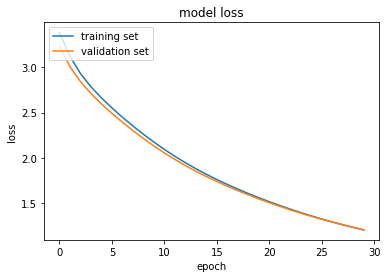

In [29]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']


plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

O comportamento acima das curvas de loss mostra que o modelo aprende bem os padrões dos dados de treinamento, ganhando mais confiança nas suas classificações. Já a curva para os dados de validação (desconhecidos para o treinamento do modelo) mostram que a *loss* se estabiliza após algumas épocas.

**O que fazer para melhorar?**

Dá para fazer muita coisa...

*   Otimização dos hiperparâmetros: altere a quantidade de camadas intermediárias, a quantidade de neurônios em cada camada intermediária, a quantidade de épocas de treinamento, o algoritmo de otimização (veja [aqui](https://keras.io/api/optimizers/) outros otimizadores);
*   Etapas de pré-processamento dos *tweets*: remoção de URLs, @'s, etc...
*   A caracterização dos *tweets* (por exemplo, o [BERT](https://keras.io/examples/nlp/text_extraction_with_bert/)!)...


### Avaliação de performance utilizando os dados de teste

Agora fazemos a classificação das instâncias do conjunto de teste utilizando o método *predict*. Observe que uma matriz é gerada na saída, em que cada linha representa um *tweet* e as colunas representam:


*   Coluna $0$: probabilidade estimada do modelo em classificar o $i$-ésimo *tweet* como sendo da classe "0" (polaridade negativa)
*   Coluna $1$: probabilidade estimada do modelo em classificar o $i$-ésimo *tweet* como sendo da classe "1" (polaridade neutra)
*   Coluna $2$: probabilidade estimada do modelo em classificar o $i$-ésimo *tweet* como sendo da classe "2" (polaridade positiva)



In [30]:
y = model.predict(X_test3)
y

array([[0.00437201, 0.00335919, 0.00253618, ..., 0.00252988, 0.00431271,
        0.00401239],
       [0.00428437, 0.00313955, 0.00259072, ..., 0.0026833 , 0.00472089,
        0.0036631 ],
       [0.00455005, 0.00353483, 0.0028764 , ..., 0.00262928, 0.00463765,
        0.00406493],
       ...,
       [0.01464352, 0.0086111 , 0.01665591, ..., 0.01973714, 0.0131097 ,
        0.01445326],
       [0.00681   , 0.00967312, 0.00711732, ..., 0.00323487, 0.00589692,
        0.01062152],
       [0.01634795, 0.06509557, 0.35965636, ..., 0.01954303, 0.01707034,
        0.00731945]], dtype=float32)

In [31]:
y_prob = model.predict(tfidf_test)
y_pred = np.argmax(y_prob,axis=1)

Vamos imprimir os resultados da classificação de *invoices* para os dados de teste:

In [32]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        60
           2       0.59      1.00      0.74       147
           3       0.94      1.00      0.97       318
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00        12
           7       0.73      1.00      0.84       138
           8       0.00      0.00      0.00        10
           9       1.00      0.05      0.09        22
          10       0.96      1.00      0.98       279
          11       1.00      0.04      0.08        24
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         4
          14       1.00      0.11      0.19        38
          15       0.93      1.00      0.96       486
          16       0.10      0.40      0.16         5
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Outra possibilidade é o uso do método *evaluate*:



In [34]:
print(model.evaluate(tfidf_test,y_test_enc))

58/58 [==============================] - 0s 4ms/step - loss: 1.2038 - accuracy: 0.8302
[1.203771710395813, 0.8301578760147095]
